### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import shuffle
%matplotlib inline

### Functions

In [38]:
class Model(nn.Module):
    def __init__(self, n_users, n_items, embed_dim, n_hidden=1024):
        super(Model, self).__init__()
        self.N = n_users
        self.M = n_items
        self.D = embed_dim

        self.u_emb = nn.Embedding(self.N, self.D)
        self.m_emb = nn.Embedding(self.M, self.D)
        self.fc1 = nn.Linear(2*self.D, n_hidden)
        self.fc2 = nn.Linear(n_hidden, 1)
    
    def forward(self, u, m):
        u = self.u_emb(u)
        m = self.m_emb(m)

        out = torch.cat((u,m),1)

        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out



def from_numpy_shuffle_all_in_one(user_ids, movie_ids, ratings):
    user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)

    user_ids_t  = torch.from_numpy(user_ids).long()
    movie_ids_t = torch.from_numpy(movie_ids).long()
    ratings_t   = torch.from_numpy(ratings).long()

    return user_ids_t, movie_ids_t, ratings_t

def make_dataset(user_ids_t, movie_ids_t, ratings_t, percentage):
    Ntrain = int(percentage * len(ratings))
    train_dataset = torch.utils.data.TensorDataset(
        user_ids_t[:Ntrain],
        movie_ids_t[:Ntrain],
        ratings_t[:Ntrain],
    )
    test_dataset = torch.utils.data.TensorDataset(
        user_ids_t[Ntrain:],
        movie_ids_t[Ntrain:],
        ratings_t[Ntrain:],
    )
    return train_dataset, test_dataset

def data_loader_maker(train_dataset, test_dataset, batch_size):
    train_loader =  torch.utils.data.DataLoader(dataset=train_dataset,
                                                batch_size = batch_size,
                                                shuffle = True
                                                )
    test_loader =  torch.utils.data.DataLoader(dataset=test_dataset,
                                                batch_size = batch_size,
                                                shuffle = True
                                                )
    
    return train_loader, test_loader


def create_model_and_train(user_ids,movie_ids,ratings,N,M,D,n_epochs=100,batch_size=512,percentage=0.8):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    
    model = Model(n_users=N, n_items=M, embed_dim=D, n_hidden=1024)
    model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())

    user_ids_t, movie_ids_t, ratings_t = from_numpy_shuffle_all_in_one(user_ids, movie_ids, ratings)
    train_dataset, test_dataset = make_dataset(user_ids_t, movie_ids_t, ratings_t, percentage)
    train_loader, test_loader = data_loader_maker(train_dataset, test_dataset, batch_size)

    train_losses = np.zeros(n_epochs)
    test_losses  = np.zeros(n_epochs)
    
    for it in range(n_epochs):
        t0 = datetime.now()
        train_loss = []
        for users, movies, targets in train_loader:
            targets = targets.view(-1,1).float()

            users, movies, targets = users.to(device), movies.to(device), targets.to(device)

            optimizer.zero_grad()
        
            outputs = model(users, movies)
            loss = criterion(outputs, targets)
        
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        
        train_losses[it] = np.mean(train_loss)


        test_loss = []
        for users, movies, targets in test_loader:
            targets = targets.view(-1,1).float()

            users, movies, targets = users.to(device), movies.to(device), targets.to(device)

        
            outputs = model(users, movies)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        
        test_losses[it] = np.mean(test_loss)

        dt = datetime.now() - t0

        # if (it+1)%5==0:

        print(f"Epoch {it+1}/{n_epochs}, Train Loss: {train_losses[it]:.4f}, Test Loss: {test_losses[it]:.4f}, Duration Time: {dt}")
        
    return model,train_losses, test_losses

def plot_metric(data, metric):
    plt.plot(data, label=metric)
    plt.legend()
    plt.show

### Download and Load data

In [2]:
!wget -nc https://files.grouplens.org/datasets/movielens/ml-20m.zip

--2021-09-27 13:02:27--  https://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M   125MB/s    in 1.5s    

2021-09-27 13:02:29 (125 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



In [3]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [4]:
df = pd.read_csv("ml-20m/ratings.csv")

In [5]:
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [6]:
# set our own 0 to N-1 ids
df.userId = pd.Categorical(df.userId)
df["new_user_id"] = df.userId.cat.codes

In [11]:
df.movieId = pd.Categorical(df.movieId)
df["new_movie_id"] = df.movieId.cat.codes

In [12]:
user_ids = df["new_user_id"].values
movie_ids = df["new_movie_id"].values
ratings = df["rating"].values - 2.5

In [19]:
print(np.max(df["rating"].values))

5.0


In [13]:
N = len(set(user_ids))
M = len(set(movie_ids))

# embedding dimension
D = 10

### Create and train model

In [39]:
%prun model,train_losses, test_losses = create_model_and_train(user_ids,movie_ids,ratings,N,M,D,n_epochs=2,batch_size=512,percentage=0.8)

cuda:0
Epoch 1/2, Train Loss: 0.6004, Test Loss: 0.5566, Duration Time: 0:06:11.687190
Epoch 2/2, Train Loss: 0.5488, Test Loss: 0.5499, Duration Time: 0:06:11.996922
 

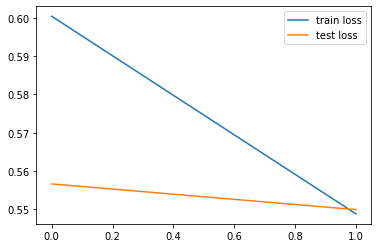

In [40]:
plot_metric(train_losses, "train loss")
plot_metric(test_losses, "test loss")